<a href="https://colab.research.google.com/github/davidelgas/DataSciencePortfolio/blob/main/Knowledge%20Graph/KG_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook I will be creating a small NN and a knowledge graph with an open source e-Commerce dataset.


My use case:<br>
A language interface (chatbot or search engine) that answers user queries.<br>
A knowledge graph to structure relationships between products, conversations, and recommendations.<br>
A PyTorch-based neural network for embeddings, retrieval, or ranking.<br>
Retrieval-Augmented Generation (RAG) to enhance responses with knowledge graph lookups.<br><br>



# Dataset
Ill be using the COOKIE dataset<br>
https://github.com/zuohuif/COOKIE<br>
https://drive.google.com/drive/folders/1gOIsuy3RSqi3UbTnfYyzgVS7msQVRKU5

# Workfow

1.   Load dataset
2.   Preprocess and Clean the Data
3.   Convert Data into a Knowledge Graph Structure
4.   Generate Knowledge Graph Embeddings
5.   Build a Graph-Based Recommendation Model
6.   Integrate Conversational AI (Natural Language Model)
7.   Train & Optimize the Full System
8.   Implement Real-Time Inference for Recommendations
9.   Deploy as an Interactive API or Chatbot
10.  Apppendx of code and notes




# Starting with an experiment that largely is already pre-built as a warm-up.



# Load Data

In [1]:
# Access to Google Drive
# This seems to propagate credentials better from its own cell

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Load the training data and do a little exploration
file_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/dial_gt_context_train.npz"
data = np.load(file_path, allow_pickle=True)

# List the arrays stored inside the file
print("Stored arrays:", data.files)

# Loop through each stored array and print its shape and a sample of its content
for key in data.files:
    array = data[key]
    print(f"\nKey: {key}")
    print(f"Shape: {array.shape}")
    print(f"Type: {type(array)}")

    # Print the first few entries for inspection
    if isinstance(array, np.ndarray):
        print(f"First 5 entries:\n{array[:5]}")
    else:
        print(f"First 5 entries (non-numpy type): {array[:5]}")


Stored arrays: ['utter_gt', 'utter_context', 'resp_gt', 'resp_context']

Key: utter_gt
Shape: (361590, 10, 1)
Type: <class 'numpy.ndarray'>
First 5 entries:
[[[169331]
  [169331]
  [169331]
  [169331]
  [169331]
  [169331]
  [135181]
  [169331]
  [128901]
  [169331]]

 [[139397]
  [169331]
  [168871]
  [169331]
  [163173]
  [169331]
  [160426]
  [169331]
  [115820]
  [169331]]

 [[128860]
  [169331]
  [118697]
  [169331]
  [114104]
  [169331]
  [109083]
  [169331]
  [115820]
  [169331]]

 [[139439]
  [169331]
  [129237]
  [169331]
  [128901]
  [169331]
  [122498]
  [169331]
  [114104]
  [169331]]

 [[139435]
  [169331]
  [137017]
  [169331]
  [129237]
  [169331]
  [114104]
  [169331]
  [115820]
  [169331]]]

Key: utter_context
Shape: (361590, 10, 24)
Type: <class 'numpy.ndarray'>
First 5 entries:
[[[169331     45 169331 ... 169331     45 169331]
  [169331     45 169331 ... 169331     45 169331]
  [169331     45 169331 ... 169331     45 169331]
  ...
  [169331     45 169331 ... 169331  

In [4]:
# Load pre-trained word embeddings

word_embed_file = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/dial_word_embed.npz"
word_embed_data = np.load(word_embed_file, allow_pickle=True)

# Check stored variables
print("Stored arrays in dial_word_embed.npz:", word_embed_data.files)

# Check the shape of embeddings
if "word_emb" in word_embed_data:
    embeddings = word_embed_data["word_emb"]
    print("Word embedding shape:", embeddings.shape)

    # Print first 5 rows
    print("First 5 word embeddings:\n", embeddings[:5])


Stored arrays in dial_word_embed.npz: ['word_emb']
Word embedding shape: (19071, 200)
First 5 word embeddings:
 [[ 1.23679310e-03  1.15482610e-03 -1.97899920e-03 -5.45953700e-05
  -2.25469450e-03 -1.73265080e-03 -2.32556490e-03  1.30943220e-03
  -7.85789160e-04  1.42404150e-03  1.80158600e-03 -1.24118350e-03
   8.28349200e-05 -2.18325430e-03 -2.46739480e-03  1.23268870e-03
  -1.08284640e-03 -5.83230050e-04  1.11434240e-03 -2.36627200e-03
  -4.59292800e-04 -2.36549000e-03  9.70530000e-04 -7.91465300e-04
   1.79398700e-03 -2.42010920e-03 -1.06402990e-03  1.60729160e-03
   1.96189950e-03  2.08600500e-03  1.66028050e-04  2.87028160e-05
   1.19609070e-03  1.69859510e-03  1.25612660e-03 -2.00261500e-03
  -6.41188640e-04  5.51312600e-04  1.38313800e-03 -1.09464240e-03
   1.00284970e-03  2.17142330e-03 -1.54237430e-03  3.29636850e-04
  -2.17077740e-05 -1.77721360e-03 -6.71590900e-04  1.82876480e-03
  -2.05638960e-03  1.86594760e-03  1.64006720e-03  8.50609200e-04
   1.77565200e-03  2.43466160e

In [5]:
# Path to dictionary

word_dict_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/word_dict.txt"

# Load the word dictionary
word_to_id = {}
id_to_word = {}

with open(word_dict_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:  # Ensure valid format
            word = parts[0]
            index = int(parts[1])
            word_to_id[word] = index
            id_to_word[index] = word  # Reverse lookup

# Check first 10 entries
print("First 10 Word-ID Mappings:")
for i, (word, index) in enumerate(word_to_id.items()):
    print(f"{index}: {word}")
    if i == 9:
        break


First 10 Word-ID Mappings:
786: militaryshield
3464: 6.6ft
8135: circuitri
12798: c-pattern-4
15378: zedari
7476: 20000mah-black
16861: rvh-ac03
3592: hanlesi
709: yellow
5354: interchang


In [6]:
# Load KG data

# File paths for KG-related files
kg_user_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_users_Cell_Phones_and_Accessories.txt"
kg_item_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_items_Cell_Phones_and_Accessories.txt"
kg_other_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_other_entities_Cell_Phones_and_Accessories.txt"

# Function to load entities
def load_entities(file_path, entity_type):
    entities = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                name, entity_id = parts
                entity_name = name.split("::")[1]  # Remove entity type prefix
                entities.append((entity_id, entity_name, entity_type))
    return entities

# Load entities
user_entities = load_entities(kg_user_entities_path, "user")
item_entities = load_entities(kg_item_entities_path, "item")
other_entities = load_entities(kg_other_entities_path, "other")

# Combine into a DataFrame
kg_entities_df = pd.DataFrame(user_entities + item_entities + other_entities, columns=["Entity_ID", "Entity_Name", "Entity_Type"])

# Display first few rows
print("First few rows of the Knowledge Graph Entities DataFrame:")
print(kg_entities_df.head())  # Print the first few rows

First few rows of the Knowledge Graph Entities DataFrame:
  Entity_ID     Entity_Name Entity_Type
0         0   A1M117A53LEI8        user
1         1  A272DUT8M88ZS8        user
2         2  A1DW2L6XCC5TJS        user
3         3   AQC61R4UST7UH        user
4         4  A31OVFL91BCKXG        user


In [8]:
# Load edges

# File paths
kg_relations_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_relations_Cell_Phones_and_Accessories.txt"
kg_train_triples_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_train_triples_Cell_Phones_and_Accessories.txt"
kg_other_triples_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_other_triples_Cell_Phones_and_Accessories.txt"

# Load Relations
relations = []
with open(kg_relations_path, "r", encoding="utf-8") as f:
    for line in f:
        relation, relation_id = line.strip().split("\t")
        relations.append((relation_id, relation))

relations_df = pd.DataFrame(relations, columns=["Relation_ID", "Relation_Name"])

# Load Triples (Train + Other)
def load_triples(file_path):
    triples = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            head, tail, relation = line.strip().split("\t")
            triples.append((head, relation, tail))
    return triples

train_triples = load_triples(kg_train_triples_path)
other_triples = load_triples(kg_other_triples_path)

# Convert to DataFrame
train_triples_df = pd.DataFrame(train_triples, columns=["Head_Entity", "Relation_ID", "Tail_Entity"])
other_triples_df = pd.DataFrame(other_triples, columns=["Head_Entity", "Relation_ID", "Tail_Entity"])

# Merge relations into triples for better readability
train_triples_df = train_triples_df.merge(relations_df, on="Relation_ID", how="left")
other_triples_df = other_triples_df.merge(relations_df, on="Relation_ID", how="left")

# Display first few rows
print("\nFirst 5 Relations:")
print(relations_df.head())

print("\nFirst 5 Train Triples:")
print(train_triples_df.head())

print("\nFirst 5 Other Triples:")
print(other_triples_df.head())



First 5 Relations:
  Relation_ID Relation_Name
0           0      purchase
1           1        review
2           2   reviewed_by
3           3   has_feature
4           4     has_price

First 5 Train Triples:
  Head_Entity Relation_ID Tail_Entity Relation_Name
0           0           0       89707      purchase
1           0           0       80789      purchase
2           0           0      106201      purchase
3           0           0       79580      purchase
4           0           0       68872      purchase

First 5 Other Triples:
  Head_Entity Relation_ID Tail_Entity Relation_Name
0           0           1      114104        review
1           0           1      115820        review
2       80789           2      114104   reviewed_by
3       80789           2      115820   reviewed_by
4       84836           2      113798   reviewed_by


# Visualizations

Graph has 106975 nodes and 361590 edges


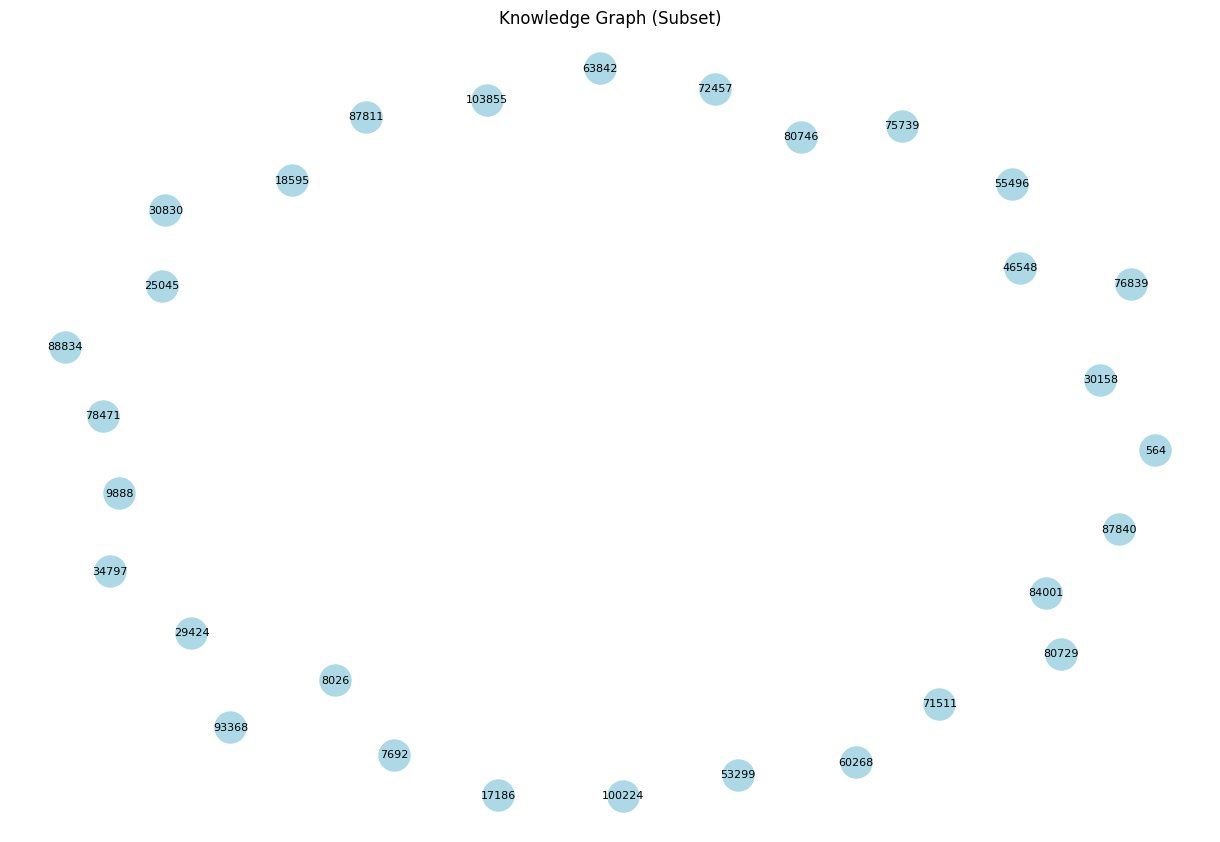

In [10]:
# Small Visualization

KG = nx.DiGraph()

# Add nodes (entities)
all_entities = set(train_triples_df["Head_Entity"]).union(set(train_triples_df["Tail_Entity"]))
KG.add_nodes_from(all_entities)

# Add edges (relationships)
edges = list(zip(train_triples_df["Head_Entity"], train_triples_df["Tail_Entity"], train_triples_df["Relation_Name"]))
KG.add_edges_from([(h, t, {"relation": r}) for h, t, r in edges])

# Display Graph Info (Fixed)
print(f"Graph has {KG.number_of_nodes()} nodes and {KG.number_of_edges()} edges")

# Visualize a small subset of the graph
plt.figure(figsize=(12, 8))
subgraph_nodes = list(all_entities)[:30]  # First 30 nodes for visualization
subgraph = KG.subgraph(subgraph_nodes)
pos = nx.spring_layout(subgraph)  # Positioning
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8)
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
plt.title("Knowledge Graph (Subset)")
plt.show()


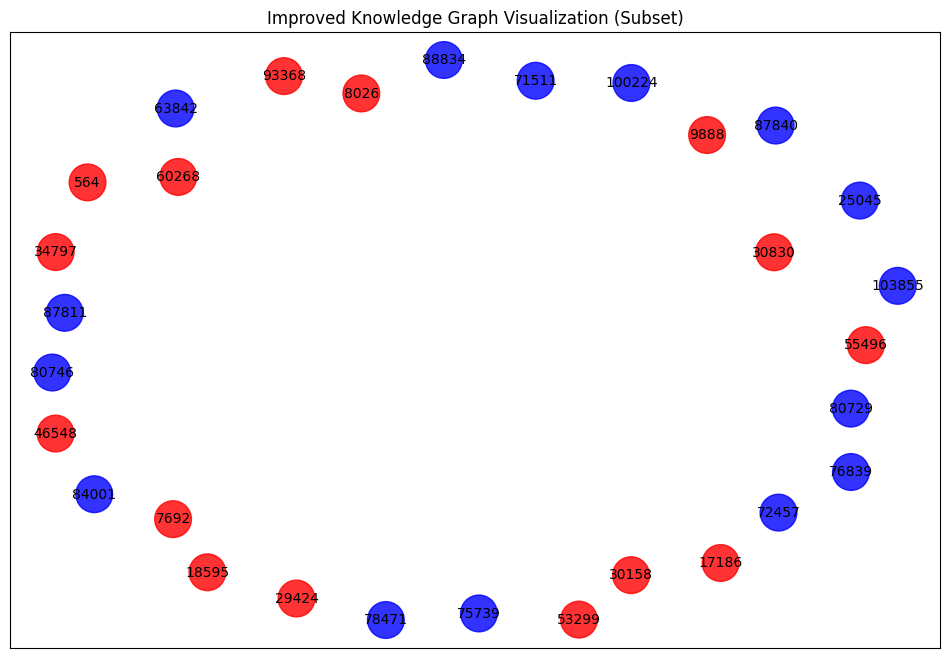

In [11]:
# Add users, items

import networkx as nx
import matplotlib.pyplot as plt

# Extract user and item entity IDs
user_entities_df = kg_entities_df[kg_entities_df["Entity_Type"] == "user"]
item_entities_df = kg_entities_df[kg_entities_df["Entity_Type"] == "item"]

# Define color mapping based on entity type
entity_colors = {"user": "red", "item": "blue", "other": "green"}

# Choose a subset of nodes for better visualization
subgraph_nodes = list(KG.nodes())[:30]  # Adjust as needed
subgraph = KG.subgraph(subgraph_nodes)

# Create a color map for only the selected subset of nodes
node_colors = []
for node in subgraph_nodes:  # Ensure colors match the subset
    if node in user_entities_df["Entity_ID"].values:
        node_colors.append("red")  # User
    elif node in item_entities_df["Entity_ID"].values:
        node_colors.append("blue")  # Item
    else:
        node_colors.append("green")  # Other

# Use a spring layout for better visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Positioning layout

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color=node_colors, alpha=0.8)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color="black")

# Draw edges with relationship labels
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edges(subgraph, pos, edge_color="gray", width=1.5, alpha=0.6)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8, font_color="darkblue")

# Title and show the improved graph
plt.title("Improved Knowledge Graph Visualization (Subset)")
plt.show()


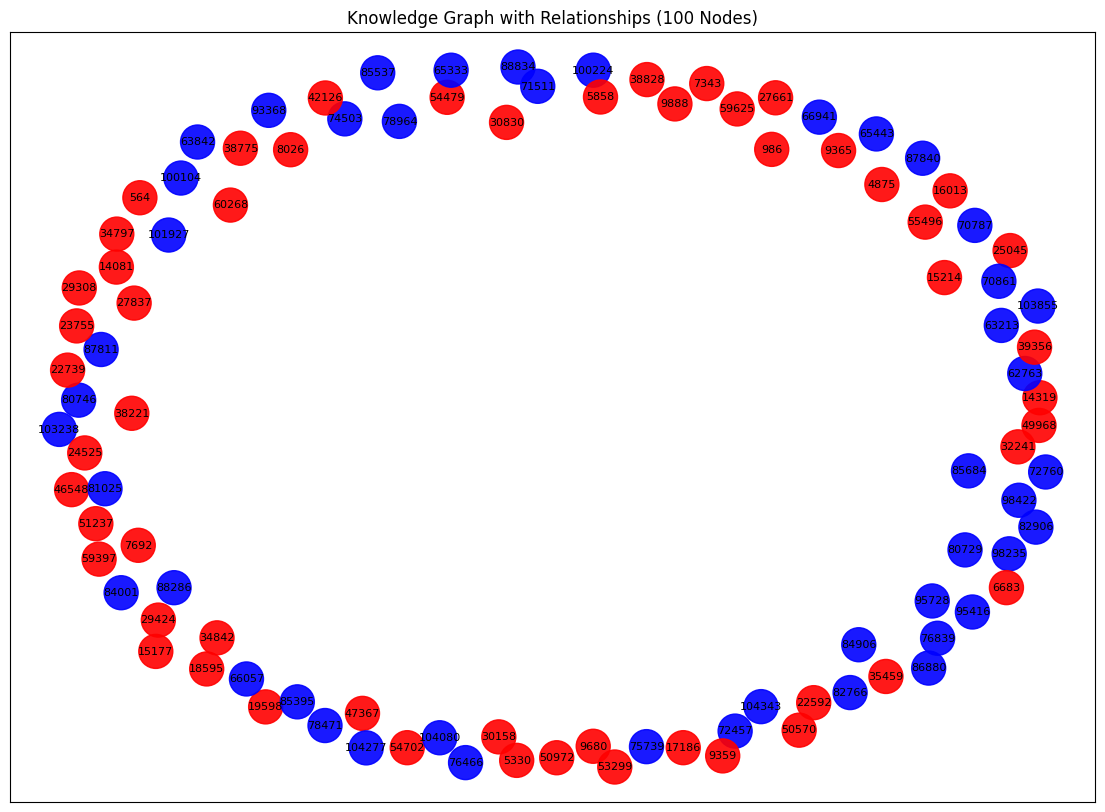

In [12]:
# Bigger plot

# Select a larger subset for visualization
subset_size = 100  # Increase sample size
subgraph_nodes = list(KG.nodes)[:subset_size]
subgraph = KG.subgraph(subgraph_nodes)

# Assign colors based on entity type
node_colors = []
for node in subgraph.nodes():
    if node in user_entities_df["Entity_ID"].values:
        node_colors.append("red")  # Users
    else:
        node_colors.append("blue")  # Items

# Generate positions
pos = nx.spring_layout(subgraph, k=0.5, seed=42)  # Adjust k for better spacing

# Plot the graph
plt.figure(figsize=(14, 10))

# **Ensure edges are drawn**
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, edge_color="gray", width=1.2)

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=600, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add edge labels for relationships
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5)

# Set title
plt.title(f"Knowledge Graph with Relationships ({subset_size} Nodes)")
plt.show()


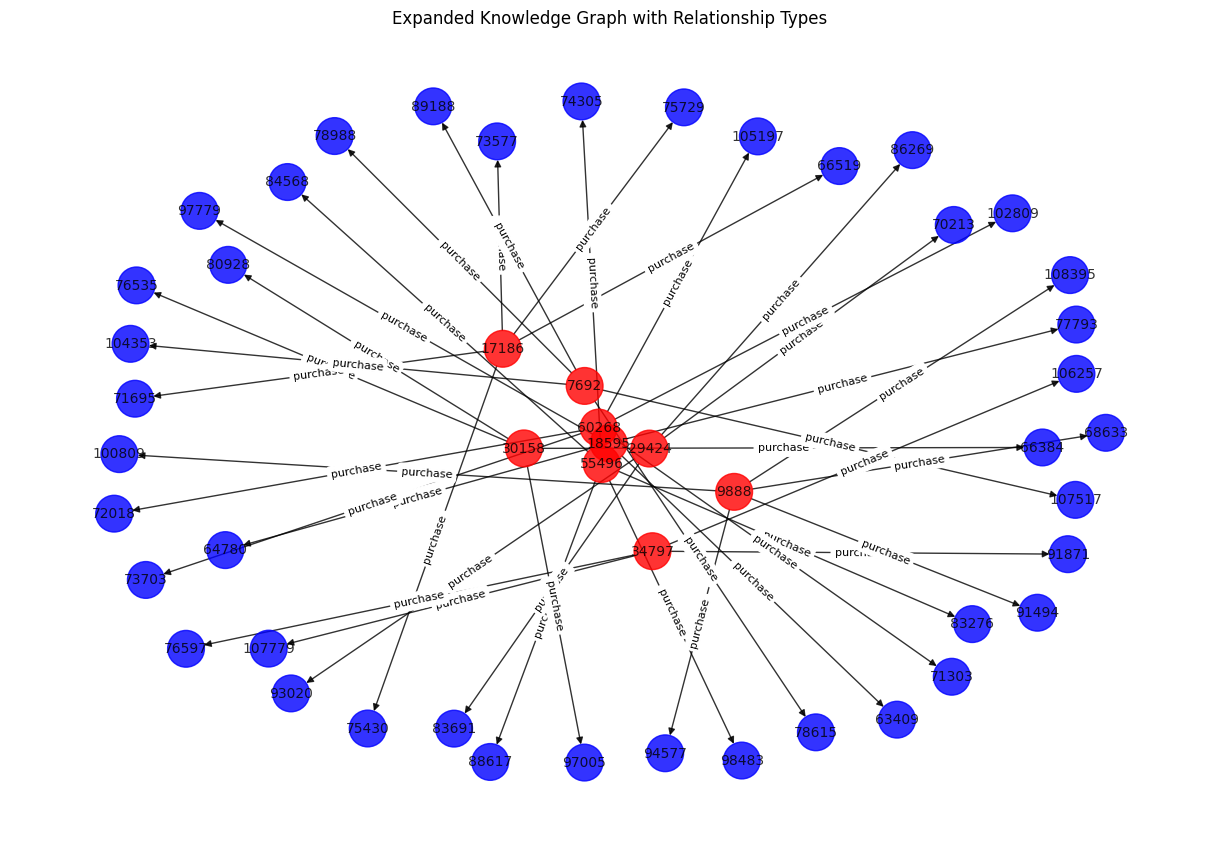

In [14]:
# Show edges and relationship detail


subgraph_nodes = set()
for h, t, r in KG.edges(data=True):
    subgraph_nodes.add(h)
    subgraph_nodes.add(t)
    if len(subgraph_nodes) >= 50:  # Increase this number for larger graphs
        break

# Create a subgraph
subgraph = KG.subgraph(subgraph_nodes)

# Define position layout
pos = nx.spring_layout(subgraph, seed=42)

# Define colors for node types
node_colors = ["red" if node in user_entities_df["Entity_ID"].values else "blue" for node in subgraph.nodes()]

# Define edge colors based on relation type
edge_colors = []
for h, t, d in subgraph.edges(data=True):
    if d["relation"] == "purchase":
        edge_colors.append("black")
    elif d["relation"] == "review":
        edge_colors.append("green")
    elif d["relation"] == "reviewed_by":
        edge_colors.append("blue")
    else:
        edge_colors.append("gray")  # Default for unknown relations

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10, edge_color=edge_colors, alpha=0.8)
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Expanded Knowledge Graph with Relationship Types")
plt.show()


Ok, that was fun. But lets create one from scratch.

# Load Data

# Convert Data into a Knowledge Graph Structure

# Generate Knowledge Graph Embeddings

# Build a Graph-Based Recommendation Model

# Integrate Conversational AI (Natural Language Model)

# Train & Optimize the Full System

# Implement Real-Time Inference for Recommendations

# Deploy as an Interactive API or Chatbot

# Appendix

## Scoring Criteria for Selecting an Encoder


| **Factor**                 | **Description** |
|---------------------------|----------------|
| **Computational Efficiency** | How fast is the encoding on CPU/GPU? |
| **Memory Usage**          | How much memory does it require? |
| **Scalability**           | Can it handle large datasets like OpenBG500? |
| **Preserves Semantic Meaning** | Does the encoding capture relationships between entities? |
| **Compatibility with PyTorch** | How well does it integrate into PyTorch models? |
| **Ease of Implementation** | How difficult is it to set up? |

Each encoding method gets a **score from 1 to 5** for each factor.

---

## Scoring Different Encoding Methods

| Encoding Method  | Computational Efficiency | Memory Usage | Scalability | Semantic Meaning | PyTorch Compatibility | Ease of Implementation | **Total Score** |
|-----------------|------------------------|--------------|-------------|------------------|----------------------|--------------------|--------------|
| **Label Encoding** (Integer Mapping) | **5** (Very fast) | **5** (Very low) | **5** (Handles millions of nodes) | **1** (No meaning captured) | **5** (PyTorch works with integers easily) | **5** (Simple `map()`) | **26** |
| **One-Hot Encoding** | **2** (Slow for large datasets) | **1** (Consumes huge memory) | **1** (Bad for large graphs) | **3** (Some structure captured) | **3** (Can be used, but not ideal) | **3** (Easy but inefficient) | **13** |
| **BERT Embeddings** (Text-Based) | **2** (Slow on CPU) | **3** (Moderate) | **3** (Can use pre-trained models) | **5** (Captures meaning well) | **4** (PyTorch supports it, but needs preprocessing) | **2** (Requires NLP model) | **19** |
| **Word2Vec/FastText** | **3** (Faster than BERT) | **3** (Moderate) | **4** (Good for large datasets) | **4** (Captures word meaning) | **4** (PyTorch supports it) | **3** (Requires preprocessing) | **21** |
| **Knowledge Graph Embeddings (TransE, RotatE)** | **4** (Moderate) | **4** (Efficient for large graphs) | **5** (Scales well) | **5** (Captures graph meaning) | **5** (Designed for PyTorch models) | **3** (Requires model training) | **26** |



In [ ]:
# Get all unique entities (from both head and tail)
all_entities = set(triples_df_train["head"]).union(set(triples_df_train["tail"]))

# Get all unique relations
all_relations = set(triples_df_train["relation"])

# Create mapping dictionaries
entity2id = {entity: idx for idx, entity in enumerate(all_entities)}
relation2id = {relation: idx for idx, relation in enumerate(all_relations)}

def encode_triples(df):
    df["head"] = df["head"].map(entity2id)
    df["relation"] = df["relation"].map(relation2id)
    df["tail"] = df["tail"].map(entity2id)
    return df

# Encode train, test, and validation sets
triples_df_train = encode_triples(triples_df_train)
triples_df_test = encode_triples(triples_df_test)
triples_df_val = encode_triples(triples_df_val)


In [ ]:
import torch

# Convert to tensor format
train_tensor = torch.tensor(triples_df_train.values, dtype=torch.long)
test_tensor = torch.tensor(triples_df_test.values, dtype=torch.long)
val_tensor = torch.tensor(triples_df_val.values, dtype=torch.long)

In [ ]:
import torch

# Check the shape of the tensors
print("Train Tensor Shape:", train_tensor.shape)
print("Test Tensor Shape:", test_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

# Access the first 5 samples
print("First 5 Training Samples:\n", train_tensor[:5])

# Get specific columns
heads = train_tensor[:, 0]  # Head entities
relations = train_tensor[:, 1]  # Relations
tails = train_tensor[:, 2]  # Tail entities

print("First 5 Head Entities:\n", heads[:5])
print("First 5 Relations:\n", relations[:5])
print("First 5 Tail Entities:\n", tails[:5])

# Perform simple operations
sum_tensor = heads + tails  # Example tensor addition
print("Sum of Head & Tail Entities:\n", sum_tensor[:5])

# Get unique values
unique_heads = torch.unique(heads)
print(f"Unique Head Entities Count: {unique_heads.shape[0]}")


In [ ]:
import torch

device = torch.device("cpu")  # Force CPU mode for now

print("Using Device:", device)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)


# Three layer network
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set dimensions
input_dim = 3  # (head, relation, tail)
hidden_dim = 16
output_dim = 1  # Binary classification or regression

# Initialize model
model = SimpleMLP(input_dim, hidden_dim, output_dim).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()  # Example: MSE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Dummy training loop
for epoch in range(5):  # Short training example
    optimizer.zero_grad()
    outputs = model(train_tensor.float())  # Convert tensor to float for Linear layers
    loss = criterion(outputs, torch.rand_like(outputs))  # Dummy target values
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
